In [2]:
!pip -q install -U diffusers transformers accelerate safetensors huggingface_hub

from google.colab import drive
from pathlib import Path
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageOps
from diffusers import AutoPipelineForInpainting


objects = ["medium-size dog", "cat", "deer", "fox", "wolf"]
angles  = ["front view", "side view", "three-quarter view", "from behind", "low angle", "slightly top-down"]

Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.
Flax classes are deprecated and will be removed in Diffusers v1.0.0. We recommend migrating to PyTorch classes or pinning your version of Diffusers.


In [3]:
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
ROOT = Path("/content/drive/MyDrive/Autonomous_Project")

MASKS_DIR  = ROOT / "data" / "subset_100" / "masks_sam3_road"
IMAGES_DIR = ROOT / "data" / "subset_100" / "images"
OUT_DIR    = ROOT / "data" / "subset_100" / "aug" / "animels"
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
img_file = next(p for p in IMAGES_DIR.iterdir() if p.is_file())

# Try same filename
candidate = MASKS_DIR / img_file.name
if candidate.exists():
    mask_file = candidate
else:
    # Try same stem
    same_stem = list(MASKS_DIR.glob(img_file.stem + ".*"))
    if len(same_stem) > 0:
        mask_file = same_stem[0]
    else:
        # Fallback (not recommended)
        mask_file = next(p for p in MASKS_DIR.iterdir() if p.is_file())

init_image = Image.open(img_file).convert("RGB")
road_mask  = Image.open(mask_file).convert("L").resize(init_image.size)

print("Image:", img_file.name)
print("Mask :", mask_file.name)

Image: 000015.png
Mask : 000015_mask.png


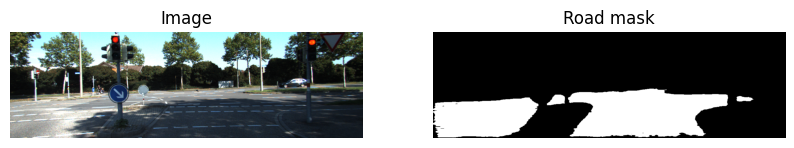

In [6]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.title("Image"); plt.imshow(init_image); plt.axis("off")
plt.subplot(1,2,2); plt.title("Road mask"); plt.imshow(road_mask, cmap="gray"); plt.axis("off")
plt.show()

In [7]:
def spot_mask_from_road(road_mask_L, image_size, spot_size=(280, 240), y_min_frac=0.65, y_max_frac=0.95):
    mask_np = np.array(road_mask_L)
    H, W = mask_np.shape

    road = mask_np > 128  # assumes road = white
    ys, xs = np.where(road)

    y_min, y_max = int(y_min_frac * H), int(y_max_frac * H)
    ok = (ys >= y_min) & (ys <= y_max)
    ys2, xs2 = ys[ok], xs[ok]

    if len(xs2) == 0:
        cx = np.random.randint(W); cy = np.random.randint(H)
    else:
        i = np.random.randint(len(xs2))
        cx, cy = int(xs2[i]), int(ys2[i])

    img_w, img_h = image_size
    w, h = spot_size

    x0, y0 = max(0, cx - w//2), max(0, cy - h//2)
    x1, y1 = min(img_w-1, cx + w//2), min(img_h-1, cy + h//2)

    spot_mask = Image.new("L", (img_w, img_h), 0)
    ImageDraw.Draw(spot_mask).ellipse([x0, y0, x1, y1], fill=255)
    return spot_mask, (cx, cy)

spot center: (192, 280)
spot_mask extrema: (0, 255)


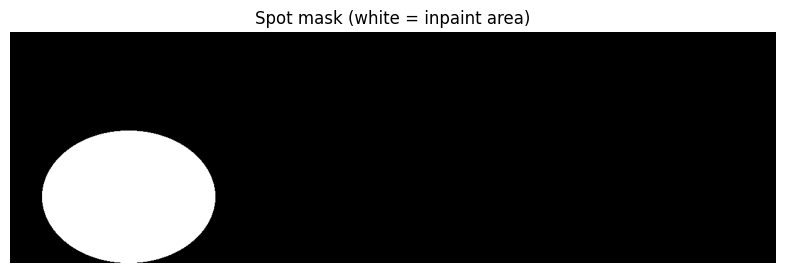

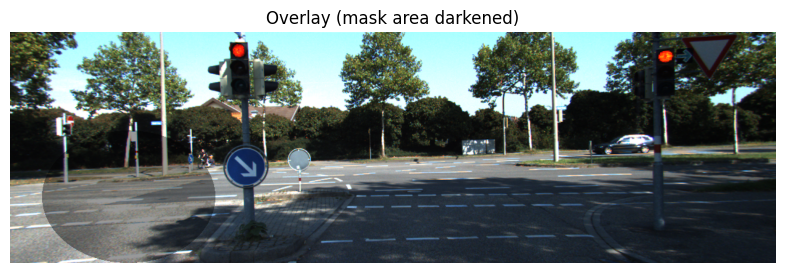

In [8]:
spot_mask, (cx, cy) = spot_mask_from_road(road_mask, init_image.size)

print("spot center:", (cx, cy))
print("spot_mask extrema:", spot_mask.getextrema())  # should be (0, 255)

plt.figure(figsize=(10,3))
plt.imshow(spot_mask, cmap="gray")
plt.title("Spot mask (white = inpaint area)")
plt.axis("off")
plt.show()

# Overlay quick check
ov = np.array(init_image).copy()
m  = np.array(spot_mask) > 10
ov[m] = (ov[m] * 0.6).astype(np.uint8)

plt.figure(figsize=(10,3))
plt.imshow(ov)
plt.title("Overlay (mask area darkened)")
plt.axis("off")
plt.show()

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"


pipe = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16,
    variant="fp16",
)

pipe.enable_model_cpu_offload()  # הכי חשוב
pipe.enable_attention_slicing()
pipe.vae.enable_slicing()
pipe.vae.enable_tiling()

pipe.enable_attention_slicing()
try:
    pipe.enable_xformers_memory_efficient_attention()
except Exception:
    pass

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/690 [00:00<?, ?B/s]

Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

scheduler_config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/746 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/758 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

text_encoder/model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

text_encoder_2/model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/725 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/659 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.fp16.safete(…):   0%|          | 0.00/5.14G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.fp16.safeten(…):   0%|          | 0.00/167M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.
`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/34 [00:00<?, ?it/s]

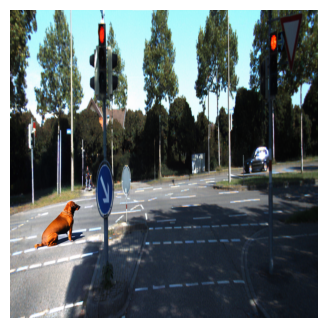

In [10]:
prompt = (
  "a realistic medium-size dog standing on the asphalt road, "
  "full body, correct scale and perspective, natural daylight, sharp focus, "
  "cast shadow on the road, photo-realistic, high detail"
)
negative = "cartoon, painting, blurry, lowres, deformed, extra legs, bad anatomy, floating, no shadow"

# start WITHOUT blur (blur can weaken mask)
out = pipe(
    prompt=prompt,
    negative_prompt=negative,
    image=init_image,
    mask_image=spot_mask,
    guidance_scale=7.5,
    num_inference_steps=20,
    strength=0.99,
).images[0]

plt.figure(figsize=(12,4))
plt.imshow(out)
plt.axis("off")
plt.show()

In [11]:
!nvidia-smi

Wed Dec 17 12:50:15 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   62C    P0             40W /   70W |     170MiB /  15360MiB |     16%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----